### 0. Imports

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import math

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.data_preparation as dp
import src.soporte_ajuste_clasificacion as sac
import src.data_visualization_support as dvs
import src.model_evaluation_support as mes

# Machine Learning tools
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.metrics import make_scorer, root_mean_squared_error, cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, classification_report

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import  RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline



# encoding
# -----------------------------------------------------------------------
from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce
# set category encoder compatibility
import sklearn
sklearn.set_config(transform_output="pandas")

# scaling
# -----------------------------------------------------------------------
from sklearn.preprocessing import  RobustScaler, StandardScaler


# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr

# model tracking
# -----------------------------------------------------------------------
import mlflow

# definir semilla random
# -----------------------------------------------------------------------
seed = 42


c:\Users\Miguel\.virtualenvs\8._Retencion_Empleados-xSKtDUkZ\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Introduction - Employee Retention - Model Evaluation

After the preprocessign exploration performed in `notebooks/3_preprocessing.ipynb`, in this notebook we will perform model evaluation for different algorithms, configurations and preprocessing options. This evaluation features scikit-learn pipelines for robust experimentation.

The evaluation ends with a model selection and business case discussion of the results.

# 2. Data import and preparation

## 2.1 Data preparation

Data preparation for load, cleaning and correction of errors found throughout the 1_exploration_cleaning, 2_EDA and 3_preprocessing notebooks have been integrated into a load and clean function, available at ``src/data_preparation.py``.

In [ ]:
list_of_paths = ["../data/general_data.csv","../data/employee_survey_data.csv","../data/manager_survey_data.csv"]

employee_attrition = dp.load_and_clean(list_of_paths, "EmployeeID")
employee_attrition

c:\Users\Miguel\Desktop\Hackio\Proyectos\8. Retencion Empleados\notebooks\..\src\data_preparation.py:86: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  employee_attrition = employee_attrition.replace(repl_dict)


,age,attrition,businesstravel,department,distancefromhome,education,educationfield,gender,joblevel,jobrole,...,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,6,1.0,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,6.0,3,5.0,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5.0,2,5.0,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,13.0,5,8.0,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,9.0,2,6.0,0,4,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,36,0,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,2,Sales Representative,...,5.0,2,1.0,0,0,2.0,4.0,3.0,3,3
4305,45,0,Travel_Rarely,Sales,1,4,Technical Degree,Male,1,Research Scientist,...,20.0,3,17.0,0,10 or more,2.0,2.0,nan,3,3
4332,31,0,Travel_Rarely,Sales,2,5,Life Sciences,Male,2,Sales Representative,...,7.0,3,4.0,0,2,nan,4.0,3.0,4,3
4395,40,0,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,1,Manufacturing Director,...,9.0,4,9.0,4,7,1.0,4.0,3.0,2,3


## 2.2 Define target and predictors

Define target and predictors, perform train-test split.

In [ ]:
y = employee_attrition["attrition"]
X = employee_attrition.drop(columns="attrition")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

Perform train and test split. Define a stratified kfold cross validation to improve metric robustness in face of target imbalance. Optimize for minimal average_precision_score, which is the equivalent of the area under the Precision-Recall curve, which is more informative than AUC for imbalanced datasets.

In [6]:
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

score = "average_precision"

verbosity = 2

# 3. Model evaluation

## 3.1 Experiment 1 - baseline

### 3.1.1 Data preprocessing

- Missing: Median imputation for numerical features. Mode for categorical.
- Outliers: False.
- Encoding: One hot encoder for <= 3 categories. Target for others.
- Scaling: False. (Only tree based models will be used)

Setting the conditions for data preprocessing:

In [260]:
categorical = X.select_dtypes("object").columns.to_list()

# current numpy version doesn't work well with np.number for this:
numerical = X.select_dtypes(["int64","float64"]).columns.to_list()

all_columns = X.columns.to_list()

columns_one_hot = [col for col in categorical if X[col].nunique() <= 3]
columns_target =[col for col in categorical if X[col].nunique() > 3]


imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline_target = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

Checking the preprocessing pipeline:

In [261]:
preprocessing_pipeline_target.fit_transform(X,y).sample(7)

,age,distancefromhome,monthlyincome,totalworkingyears,yearsatcompany,businesstravel_Travel_Rarely,businesstravel_Travel_Frequently,businesstravel_Non-Travel,department_Sales,department_Research & Development,...,percentsalaryhike,trainingtimeslastyear,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating_3,performancerating_4
4409,40.0,28.0,54680.0,10.0,21.0,1,0,0,0,1,...,0.154206,0.057833,0.16947,0.087498,0.247492,0.166667,0.122662,0.174194,1,0
1294,55.0,2.0,74410.0,24.0,1.0,1,0,0,0,1,...,0.154206,0.12782,0.137931,0.313793,0.247492,0.112245,0.140127,0.154341,1,0
120,34.0,7.0,56170.0,9.0,5.0,0,0,1,0,1,...,0.180444,0.172414,0.192,0.116516,0.247492,0.112245,0.170868,0.154341,0,1
545,34.0,1.0,26960.0,6.0,0.0,0,0,1,1,0,...,0.180444,0.172414,0.192,0.313793,0.139004,0.112245,0.140127,0.154341,0,1
1278,36.0,3.0,20180.0,6.0,6.0,0,1,0,0,1,...,0.172727,0.131783,0.192,0.14094,0.148026,0.165541,0.140127,0.154341,1,0
1,31.0,10.0,41890.0,6.0,5.0,0,1,0,0,1,...,0.180444,0.172414,0.137931,0.116516,0.139004,0.165541,0.179487,0.156962,0,1
2730,46.0,20.0,40350.0,14.0,9.0,0,1,0,0,1,...,0.136364,0.174873,0.192,0.094832,0.247492,0.112245,0.140127,0.154341,1,0


### 3.1.2 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [ ]:
models = {
    'decision_tree': (
        DecisionTreeClassifier(random_state=seed),
        {
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [5, 10, 15],
            'classifier__min_samples_leaf': [2, 5, 10],
            'classifier__max_leaf_nodes': [20, 30, None],
            'classifier__max_features': ['sqrt', 'log2']
        }
    ),

    'random_forest': (
        RandomForestClassifier(random_state=seed, n_jobs=-1),
        {
            'classifier__n_estimators': [50, 100, 150, 200],
            'classifier__max_depth': [10, 15, 20, 25],
            'classifier__min_samples_split': [2, 5, 10, 15],
            'classifier__min_samples_leaf': [1, 5, 10],
            'classifier__bootstrap': [True, False]
        }
    ),

    'xgboost': (
        XGBClassifier(n_jobs=-1, random_state=seed),
        {
            'classifier__n_estimators': [50, 75],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3,5],
            'classifier__min_child_weight': [1, 2],
            'classifier__colsample_bytree': [0.8,0.9],
            'classifier__gamma': [0.05, 1, 1.5],
            'classifier__reg_alpha': [0.05, 0.1],
            'classifier__reg_lambda': [1],
        }
    )


}


### 3.1.3 Run experiment

Evaluate Decision Tree:

In [264]:
analista_clasificacion_1 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="imp. simple, OHE + TE")

analista_clasificacion_1.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["decision_tree"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_1.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.878378,0.868413,0.878378,0.857853,0.416961,0.892812,0.642511,0.333141,0.066734,12.0
test,0.819048,0.760918,0.819048,0.779788,0.074723,0.647774,0.256344,0.333141,0.066734,12.0


Evaluate Random Forest:

In [265]:
analista_clasificacion_1.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_1.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.965819,0.967156,0.965819,0.964124,0.861263,0.999916,0.999588,1.158217,0.192664,12.0
test,0.857143,0.846509,0.857143,0.812635,0.198473,0.763396,0.525138,1.158217,0.192664,12.0


Evaluate Xgboost:

In [266]:
analista_clasificacion_1.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["xgboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_1.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.880763,0.885281,0.880763,0.852854,0.385470,0.904487,0.735957,0.350758,0.077626,12.0
test,0.857143,0.840482,0.857143,0.816371,0.217499,0.702340,0.413048,0.350758,0.077626,12.0


Inspect best parameters of each:

In [267]:
for model in models.keys():
    print(f"{model} - best params:")
    display(analista_clasificacion_1.resultados[model]["best_params"])

decision_tree - best params:


{'classifier__max_depth': 10,
 'classifier__max_features': 'log2',
 'classifier__max_leaf_nodes': None,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 15}

random_forest - best params:


{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 200}

xgboost - best params:


{'classifier__colsample_bytree': 0.9,
 'classifier__gamma': 0.05,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__min_child_weight': 2,
 'classifier__n_estimators': 50,
 'classifier__reg_alpha': 0.05,
 'classifier__reg_lambda': 1}

Compare Kappa's accross thresholds:

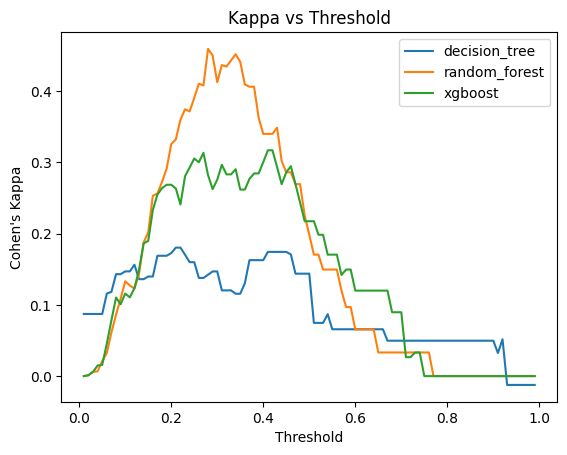

In [ ]:
analista_clasificacion_1.plot_score_by_threshold( model_names = models.keys(), scorer=cohen_kappa_score, scorer_name='Cohen\'s Kappa')

## 3.2 Experiment 2

### 3.2.1 Data preprocessing

Same, only changing the TargetEncoder for a CatBoost encoder.

In [274]:
preprocessing_pipeline_catboost_encoder = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.CatBoostEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

### 3.2.2 Models to compare

Same ones as before.

### 3.2.3 Run experiment

In [ ]:
analista_clasificacion_2 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="imp. simple, OHE + CatBE")

Evaluate Decision Tree:

In [275]:
analista_clasificacion_2.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["decision_tree"][1], 
                                        cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.841812,0.800990,0.841812,0.791875,0.118533,0.667815,0.335310,0.261641,0.084657,12.0
test,0.825397,0.761969,0.825397,0.779821,0.065786,0.647283,0.272054,0.261641,0.084657,12.0


Evaluate XGboost:

In [276]:
analista_clasificacion_2.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["xgboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.860890,0.861427,0.860890,0.817911,0.229474,0.793584,0.544504,0.345605,0.122362,12.0
test,0.853968,0.833776,0.853968,0.810415,0.190503,0.650943,0.383334,0.345605,0.122362,12.0


Evaluate Random Forest:

In [277]:
analista_clasificacion_2.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.875199,0.883453,0.875199,0.842119,0.336493,0.922986,0.757400,1.285087,0.240375,12.0
test,0.853968,0.833776,0.853968,0.810415,0.190503,0.726792,0.429337,1.285087,0.240375,12.0


Compare Kappa's accross thresholds:

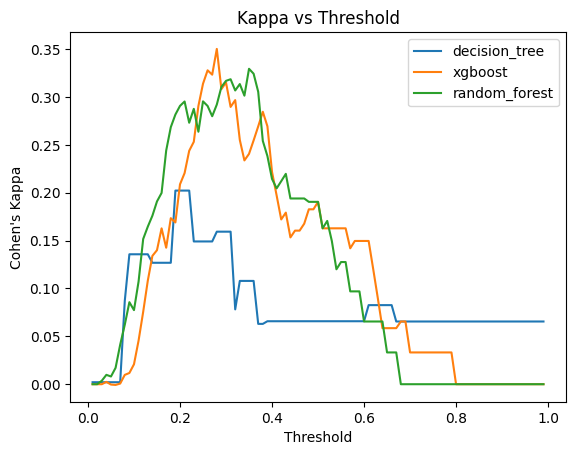

In [278]:
analista_clasificacion_2.plot_cohens_kappa(["decision_tree", "xgboost","random_forest"])

## 3.3 Experiment 3

### 3.3.1 Data preprocessing

Simple imputer. Encoding not needed for CatBoost.

Catboost, not optimized. A small number of iterations will be tested as it is a quite intensive algorithm.

No encoding is needed.

In [ ]:


preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer)
])

### 3.2.3 Models to compare

Catboost:

In [ ]:
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__iterations': [50,100,150]
        }
    )

### 3.3.3 Run experiment

In [280]:
analista_clasificacion_3 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="catboost - n_iterations")

analista_clasificacion_3.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_3.calcular_metricas("catboost")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.064718
0:	learn: 0.2239805	total: 53.8ms	remaining: 8.02s
100:	learn: 0.8090912	total: 5.13s	remaining: 2.49s
149:	learn: 0.8865501	total: 7.89s	remaining: 0us


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.889507,0.895484,0.889507,0.866224,0.444442,0.91775,0.782561,10.896863,0.012884,12.0
test,0.879365,0.885250,0.879365,0.849273,0.361940,0.75366,0.530867,10.896863,0.012884,12.0


Display best parameters:

In [ ]:
analista_clasificacion_3.resultados["catboost"]["mejor_modelo"]["classifier"].get_params()

None

{'verbose': 100,
 'custom_metric': 'PRAUC',
 'eval_metric': 'PRAUC',
 'random_state': 42,
 'early_stopping_rounds': 50,
 'cat_features': ['businesstravel',
  'department',
  'education',
  'educationfield',
  'gender',
  'joblevel',
  'jobrole',
  'maritalstatus',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'trainingtimeslastyear',
  'yearssincelastpromotion',
  'yearswithcurrmanager',
  'environmentsatisfaction',
  'jobsatisfaction',
  'worklifebalance',
  'jobinvolvement',
  'performancerating'],
 'iterations': 150}

Plot kappa's curve accross threholds:

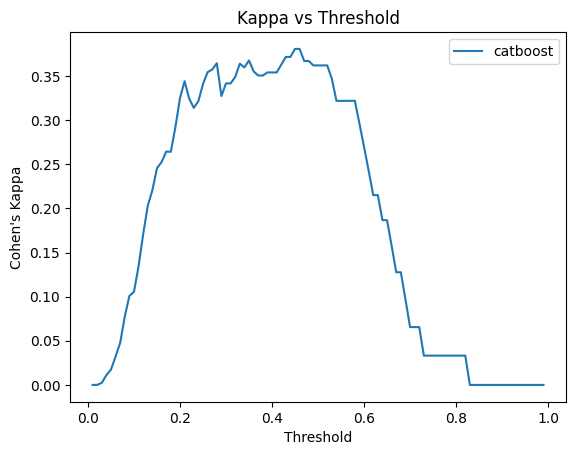

In [282]:
analista_clasificacion_3.plot_cohens_kappa(["catboost"])

## 3.4 Experiment 4

### 3.3.1 Data preprocessing

Again, just a simple imputer.

In [ ]:
imputer_catboost = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy="constant", fill_value="NaN"), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer_catboost)
])

### 3.2.3 Models to compare

Catboost for different optimization parameters.

In [ ]:
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__depth': [6,8,10],
            'classifier__l2_leaf_reg': [1, 3, 5],
            'classifier__border_count': [32, 64],
            'classifier__bagging_temperature': [0.5, 1],
            'classifier__iterations': [50,100,150]
        }
    )

### 3.3.3 Run experiment

In [284]:
analista_clasificacion_4 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="catboost - tuned")

analista_clasificacion_4.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_4.calcular_metricas("catboost")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0:	learn: 0.3038797	total: 103ms	remaining: 15.4s
100:	learn: 0.9759195	total: 8.86s	remaining: 4.3s
149:	learn: 0.9974526	total: 13.5s	remaining: 0us


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.911765,0.920157,0.911765,0.897254,0.579188,0.983217,0.945950,23.610671,0.023023,12.0
test,0.860317,0.852407,0.860317,0.818658,0.225698,0.762792,0.504613,23.610671,0.023023,12.0


Somehow, Catboost works best when no other hyperparameters other than the iterations number is modified. Or at the very least, there is one parameter that should not be modified (learning rate is for sure one of them) and throws off the whole optimization.

In [ ]:
analista_clasificacion_4.resultados["catboost"]["mejor_modelo"]["classifier"].get_params()

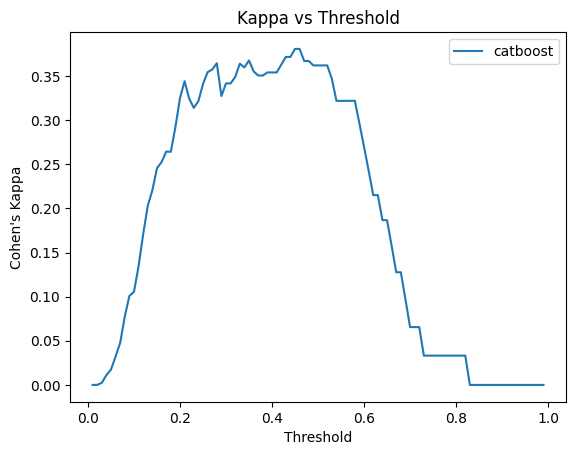

In [286]:
analista_clasificacion_3.plot_cohens_kappa(["catboost"])

## 3.5 Experiment 5

### 3.5.1 Data preprocessing

Simple imputer for Catboost.

First pipeline of imputation, OHE + TE for Random Forest.

In [ ]:


imputer_catboost = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy="most_frequent"), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer_catboost)
])



### 3.5.2 Models to compare

Catboost vs. Random Forest for 'balanced' weights to combat target imbalance.

In [ ]:
# redefine catboost for simpler first model.
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__iterations': [50,100,150],
            'classifier__auto_class_weights': ['Balanced']
        }
    )

#  Random Forest stays equal but gets added 'balanced' weights
models["random_forest"][1]["classifier__class_weight"] = ['balanced']

### 3.5.3 Run experiments

In [288]:
analista_clasificacion_5 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="RF & CatB - balanced weights")

analista_clasificacion_5.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, 
                                        param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_5.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.962639,0.962716,0.962639,0.962676,0.861686,0.990718,0.949346,0.840637,0.172486,12.0
test,0.838095,0.814397,0.838095,0.821908,0.283292,0.710038,0.458021,0.840637,0.172486,12.0


In [290]:
analista_clasificacion_5.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_5.calcular_metricas("catboost")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.064718
0:	learn: 0.7419879	total: 44.9ms	remaining: 6.69s
100:	learn: 0.9460566	total: 6.26s	remaining: 3.04s
149:	learn: 0.9860352	total: 10.3s	remaining: 0us


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.880763,0.905812,0.880763,0.888556,0.621358,0.942535,0.801837,12.541498,0.013708,12.0
test,0.822222,0.845848,0.822222,0.831716,0.410822,0.761434,0.500947,12.541498,0.013708,12.0


## 3.6 Experiment 6

### 3.6.1 Data preprocessing

In [ ]:
custom_one_hot_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=2, sparse_output=False)

# Define the SMOTE-NC and Tomek Links steps
smote_nc = SMOTENC(categorical_features=categorical, random_state=seed, sampling_strategy=0.75, categorical_encoder=custom_one_hot_encoder)
tomek_links = TomekLinks(sampling_strategy='majority')

imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median', add_indicator=False), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent', add_indicator=False), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline_target_SMOTE = ImbPipeline([
    ('imputer', imputer),
    ('smote_nc', smote_nc),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True)),
    ('tomek_links', tomek_links)
])

Checking the preprocessing pipeline:

In [293]:
X_transformed = preprocessing_pipeline_target_SMOTE.fit_resample(X,y)
X_transformed[1].value_counts()

attrition
0    1137
1     990
Name: count, dtype: Int64

### 3.6.2 Models to compare

Random Forest with SMOTE to combat target feature imbalance.

### 3.6.3 Run experiments

In [303]:
analista_clasificacion_6 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="RF - OHE + TE + SMOTE")

analista_clasificacion_6.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_6.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.962639,0.962716,0.962639,0.962676,0.861686,0.990718,0.949346,0.86018,0.184302,12.0
test,0.838095,0.814397,0.838095,0.821908,0.283292,0.710038,0.458021,0.86018,0.184302,12.0


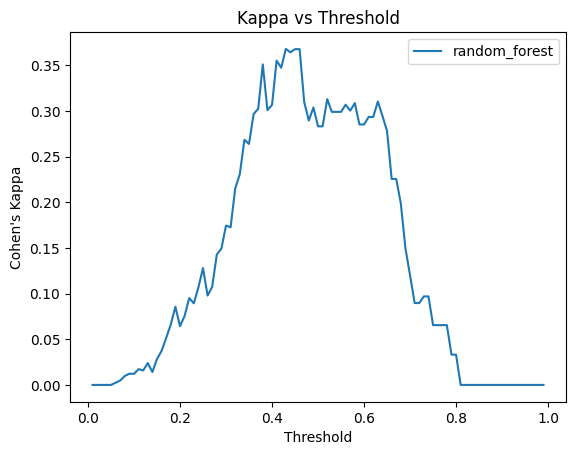

In [295]:
analista_clasificacion_6.plot_cohens_kappa(["random_forest"])

# 4. Model comparison and discussion

## 4.1 Metric comparison

Create total results dataframe for model comparison.

In [296]:
df_total = pd.DataFrame()
for i in range(1, 7):
    # use locals variable dict to dinamically access the analista_clasificacion objects
    analista_clasificacion_i = locals().get(f"analista_clasificacion_{i}")

    for model_name, model in models.items():
        try:
            df_metricas = analista_clasificacion_i.calcular_metricas(model_name)
            df_metricas["model"] = model_name
            df_metricas["iteration"] = analista_clasificacion_i.iteracion
            df_total = pd.concat([df_total,df_metricas],axis=0)
        except:
            continue

# get train_test column
df_total = (df_total.reset_index()
            .rename(columns={"index":"train_test"})
            .sort_values(by=["model","iteration"]))
df_total.style.apply(sac.color_filas_por_modelo, axis=1)

,train_test,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs,model,iteration
18,train,0.880763,0.905812,0.880763,0.888556,0.621358,0.942535,0.801837,12.541498,0.013708,12.000000,catboost,RF & CatB - balanced weights
19,test,0.822222,0.845848,0.822222,0.831716,0.410822,0.761434,0.500947,12.541498,0.013708,12.000000,catboost,RF & CatB - balanced weights
12,train,0.889507,0.895484,0.889507,0.866224,0.444442,0.917750,0.782561,10.896863,0.012884,12.000000,catboost,catboost - n_iterations
13,test,0.879365,0.885250,0.879365,0.849273,0.361940,0.753660,0.530867,10.896863,0.012884,12.000000,catboost,catboost - n_iterations
14,train,0.911765,0.920157,0.911765,0.897254,0.579188,0.983217,0.945950,23.610671,0.023023,12.000000,catboost,catboost - tuned
15,test,0.860317,0.852407,0.860317,0.818658,0.225698,0.762792,0.504613,23.610671,0.023023,12.000000,catboost,catboost - tuned
6,train,0.841812,0.800990,0.841812,0.791875,0.118533,0.667815,0.335310,0.261641,0.084657,12.000000,decision_tree,"imp. simple, OHE + CatBE"
7,test,0.825397,0.761969,0.825397,0.779821,0.065786,0.647283,0.272054,0.261641,0.084657,12.000000,decision_tree,"imp. simple, OHE + CatBE"
0,train,0.878378,0.868413,0.878378,0.857853,0.416961,0.892812,0.642511,0.333141,0.066734,12.000000,decision_tree,"imp. simple, OHE + TE"
1,test,0.819048,0.760918,0.819048,0.779788,0.074723,0.647774,0.256344,0.333141,0.066734,12.000000,decision_tree,"imp. simple, OHE + TE"


Now, with the results from the evaluations performed until now, let's visually inspect observe which have performed best.

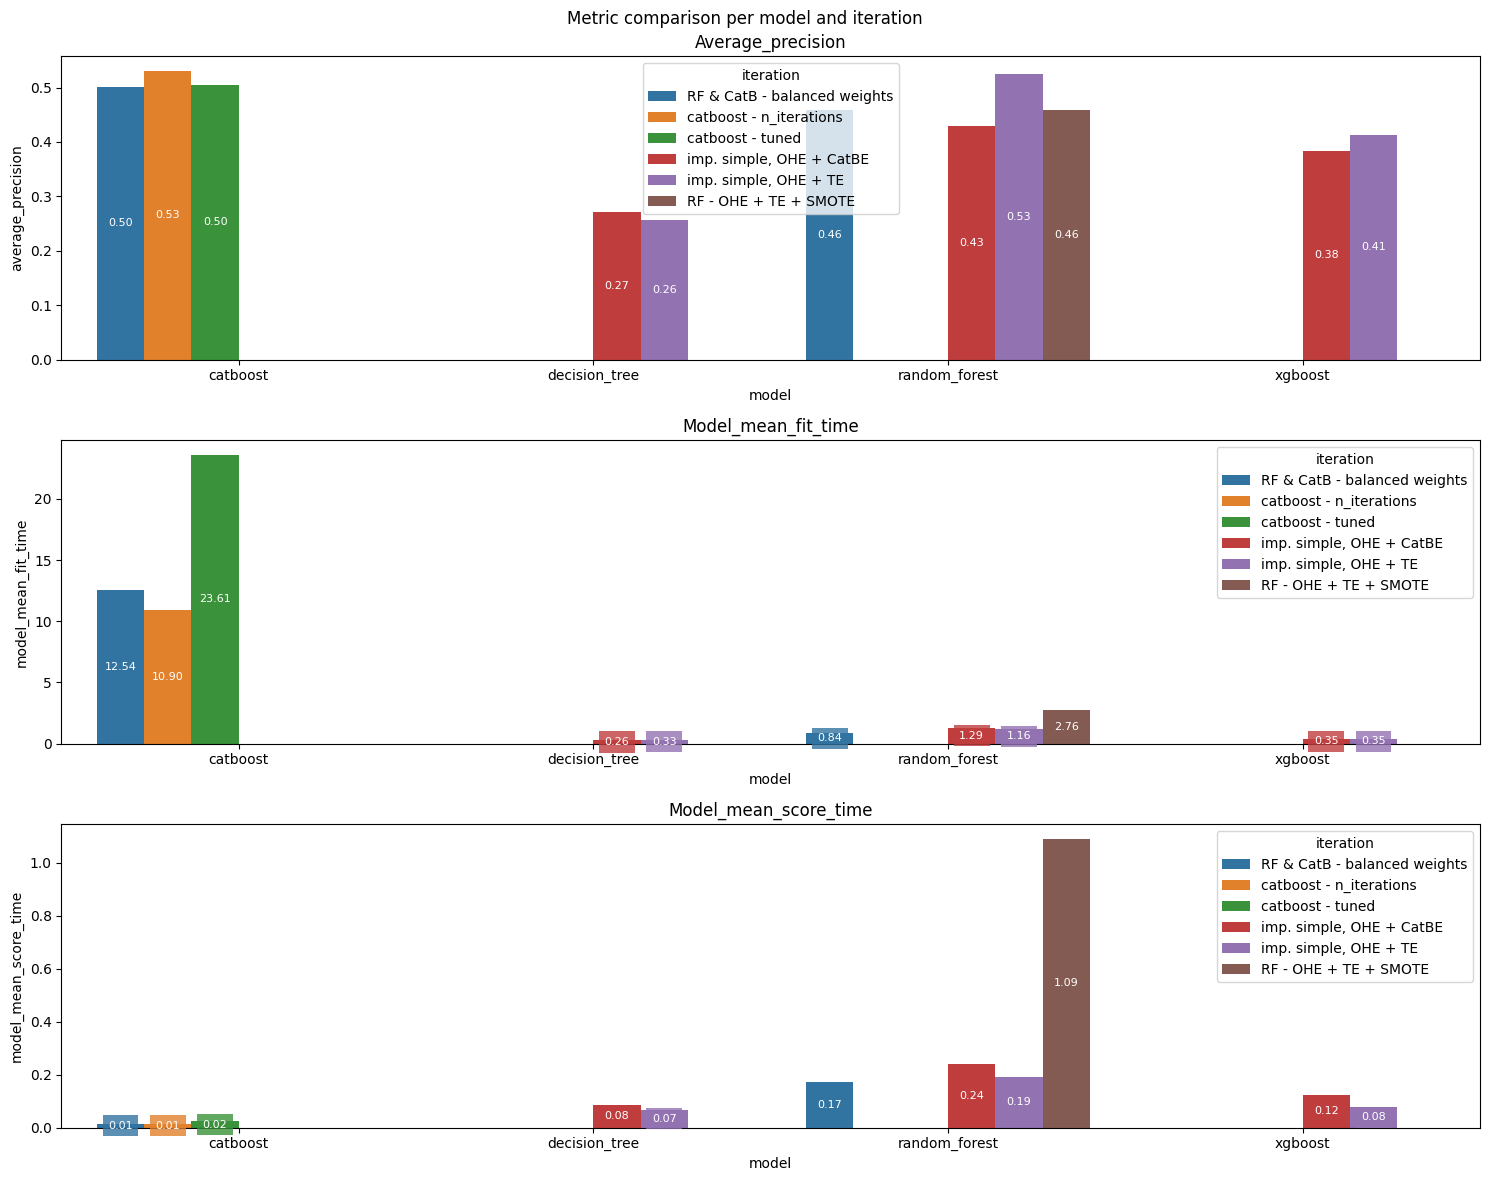

In [298]:

# plot subplot for every metric in this list
metrics = ["average_precision","model_mean_fit_time","model_mean_score_time"]

fig, axes = plt.subplots(len(metrics),1,figsize=(15,len(metrics)*4))
axes = axes.flat

fig.suptitle("Metric comparison per model and iteration")


for ax, metric in zip(axes, metrics):
    ax.set_title(f"{metric.capitalize()}")

    sns.barplot(data=df_total[df_total["train_test"]=="test"],
                x="model",
                y=metric,
                hue="iteration", ax=ax)
    
    dvs.plot_bar_labels(ax)
    
plt.tight_layout()
plt.show()

### 4.1.1 General comments on models
#### 4.1.1.1 AUC-PR metric performance
In terms of metric performance, we are looking at high Areas Under Curve for Precision Recall, (AUC-PR). This metric is the equivalent to ROC-AUC, with the distinction that it does not look at the True Negative Performance, as the False Positive Rate naturally does. For imbalanced datasets, this allows to focus on the performance of the Positive class by looking at the balance of Precision and Recall for the whole classification threshold spectrum.

From the above graph, it is clear that overall, CatBoost is a phenomenal algorithm that does not need much tuning to perform. In fact, the best iteration of all is the one where just the number of boosting iterations where tuned (that is something to explore in next steps).

Following closely, there is Random Forest. In the iteration with Simple Imputing, One Hot Encoding for features <=3 categories and Target Encoding for the remaining ones, it is on par with CatBoost.

Next, there is XGBoost, which does not show such amazing performance in terms of AUC-PR, but as one can see in the second graph. And finally there is the Decision Tree, the worst of them all performance-wise. From now all, we will not discuss it as a production viable solution.

#### 4.1.1.2 Training time
Therefore, now comparing just Catboost, Decision Tree and Random Forest, XGBoost is the best in terms of **training time**. It strikes a good balance in terms of computation and performance for training time, thus it is a good alternative if training time is a constraint. Random Forest is about 4 times slower, while CatBoost takes an enormous time to train, taking up to more than 18 times more to train than Random Forest. This makes CatBoost ressource intensive compared to the other 2 algorithms if heavy-duty parameter optimization is performed.

However, once tuned and optimized, it is important to ponder whether this time will be important, and that will depend upon how much retraining is forecasted to be necessary in the future. If not much retraining will be needed, what gains importance is how this model will behave in terms of inference time, specially for real-time inference endpoints in batches.

#### 4.1.1.3 Scoring time
For inference times, we are looking at scoring time. Here CatBoost makes a huge improvement, displaying a scoring time of just 0.023 seconds at most, twice as fast than the fastest Decision Tree and XGBoost models at around 0.07 seconds. Random Forest displays 0.19 seconds for its best iteration in terms of AUC-PR. 

Taking into account that this times are calculated for no single-line inference but for small batches, the actual absolute difference in seconds for single-row predicitions in terms of scoring time would be negligible.

### 4.1.2 Comments on techniques used

#### 4.1.2.1 Preprocessing

#### 4.1.2.2 Balancing techniques

Three approaches to battle target imbalanced have been used:
1. No additional preprocessing. Hypothesis: Applying weights and resampling techniques changes the picture the model has of the underlying distritribution. Classification threshold alone should suffice.
2. Class weights balancing. Hypothesis: Changing the weights of the model towards penalizing wrong predictions of the positive class more can make it improve it's predicted probability distribution.
3. Oversampling + undersampling. Hypothesis: Creating artificial instances of the positive class + removing too similar instances of the negative class can assist the model in predicting the positive class better.

For 2. Class weights balancing comparison, the same configurations of 2 models have been used, CatBoost with minimal optimization and Random Forest with OHE + TE. In both cases, performance worsened in terms of AUC-PR.

For 3. Oversampling + undersampling with SMOTE and Tomeklink, the models failed to improve their metrics of AUC-PR.

Therefore, the option to not play with weights or resampling is chosen, deciding to improve classification by proper optimization of the classification threshold based on metric prioritization.

## 4.1 Model selection
To finally select a model, it is necessary to take the most promising ones in terms of summary metric like AUC-PR and scoring time and evaluate how their metrics would do at specific thresholds for the metrics of interest, in this case:
- Recall - Precision balance: Recall is more important than Precision here, meaning that we are willing to make False Positives for the sake of correctly identifying those employees that could leave the company, as we want to take specific measures to retain the most valuable ones. 
- Kappa: Although focused in Recall, we can use Kappa to support decisions about optimal classification thresholds.

Then, a comparison of feature importances and SHAP values will be helpful to:
- Understand how the model makes predictions and validate its correctness with our logic and analysis
- Extract new business insights

Finally, a probability calibration will be necessary to assess whether probabilities are correctly assigned to each class. Probability thresholds gain importance for imlabanced problems, and the correct tuning of thresholds depends on it.

## 4.2 CatBoost & Random Forest post-hoc

The 2 best models to select are the best results of the following CV:
- Random Forest, simple imputing + OHE + TE
- Catboost, n_iterations tuned

### 4.2.1 Parameters

In [309]:
print("Configuración de parámetros del modelo Random Forest")
display(analista_clasificacion_1.resultados["random_forest"]["mejor_modelo"]["classifier"].get_params())

print("\nConfiguración de parámetros del modelo Catboost")
display(analista_clasificacion_3.resultados["catboost"]["mejor_modelo"]["classifier"].get_params())

Configuración de parámetros del modelo Random Forest


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Configuración de parámetros del modelo Catboost


{'verbose': 100,
 'custom_metric': 'PRAUC',
 'eval_metric': 'PRAUC',
 'random_state': 42,
 'early_stopping_rounds': 50,
 'cat_features': ['businesstravel',
  'department',
  'education',
  'educationfield',
  'gender',
  'joblevel',
  'jobrole',
  'maritalstatus',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'trainingtimeslastyear',
  'yearssincelastpromotion',
  'yearswithcurrmanager',
  'environmentsatisfaction',
  'jobsatisfaction',
  'worklifebalance',
  'jobinvolvement',
  'performancerating'],
 'iterations': 150}

### 4.2.2 Threshold metric comparison

Focusing on the metrics of these 2 models:

In [354]:
mask_model = df_total["model"].isin(["catboost","random_forest"])
mask_iteration = df_total["iteration"].isin(["catboost - n_iterations","imp. simple, OHE + TE"])
df_total[mask_model & mask_iteration].style.apply(sac.color_filas_por_modelo, axis=1)

,train_test,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs,model,iteration
12,train,0.889507,0.895484,0.889507,0.866224,0.444442,0.917750,0.782561,10.896863,0.012884,12.000000,catboost,catboost - n_iterations
13,test,0.879365,0.885250,0.879365,0.849273,0.361940,0.753660,0.530867,10.896863,0.012884,12.000000,catboost,catboost - n_iterations
2,train,0.965819,0.967156,0.965819,0.964124,0.861263,0.999916,0.999588,1.158217,0.192664,12.000000,random_forest,"imp. simple, OHE + TE"
3,test,0.857143,0.846509,0.857143,0.812635,0.198473,0.763396,0.525138,1.158217,0.192664,12.000000,random_forest,"imp. simple, OHE + TE"


Let's plot comparisons for the different metrics of interest.

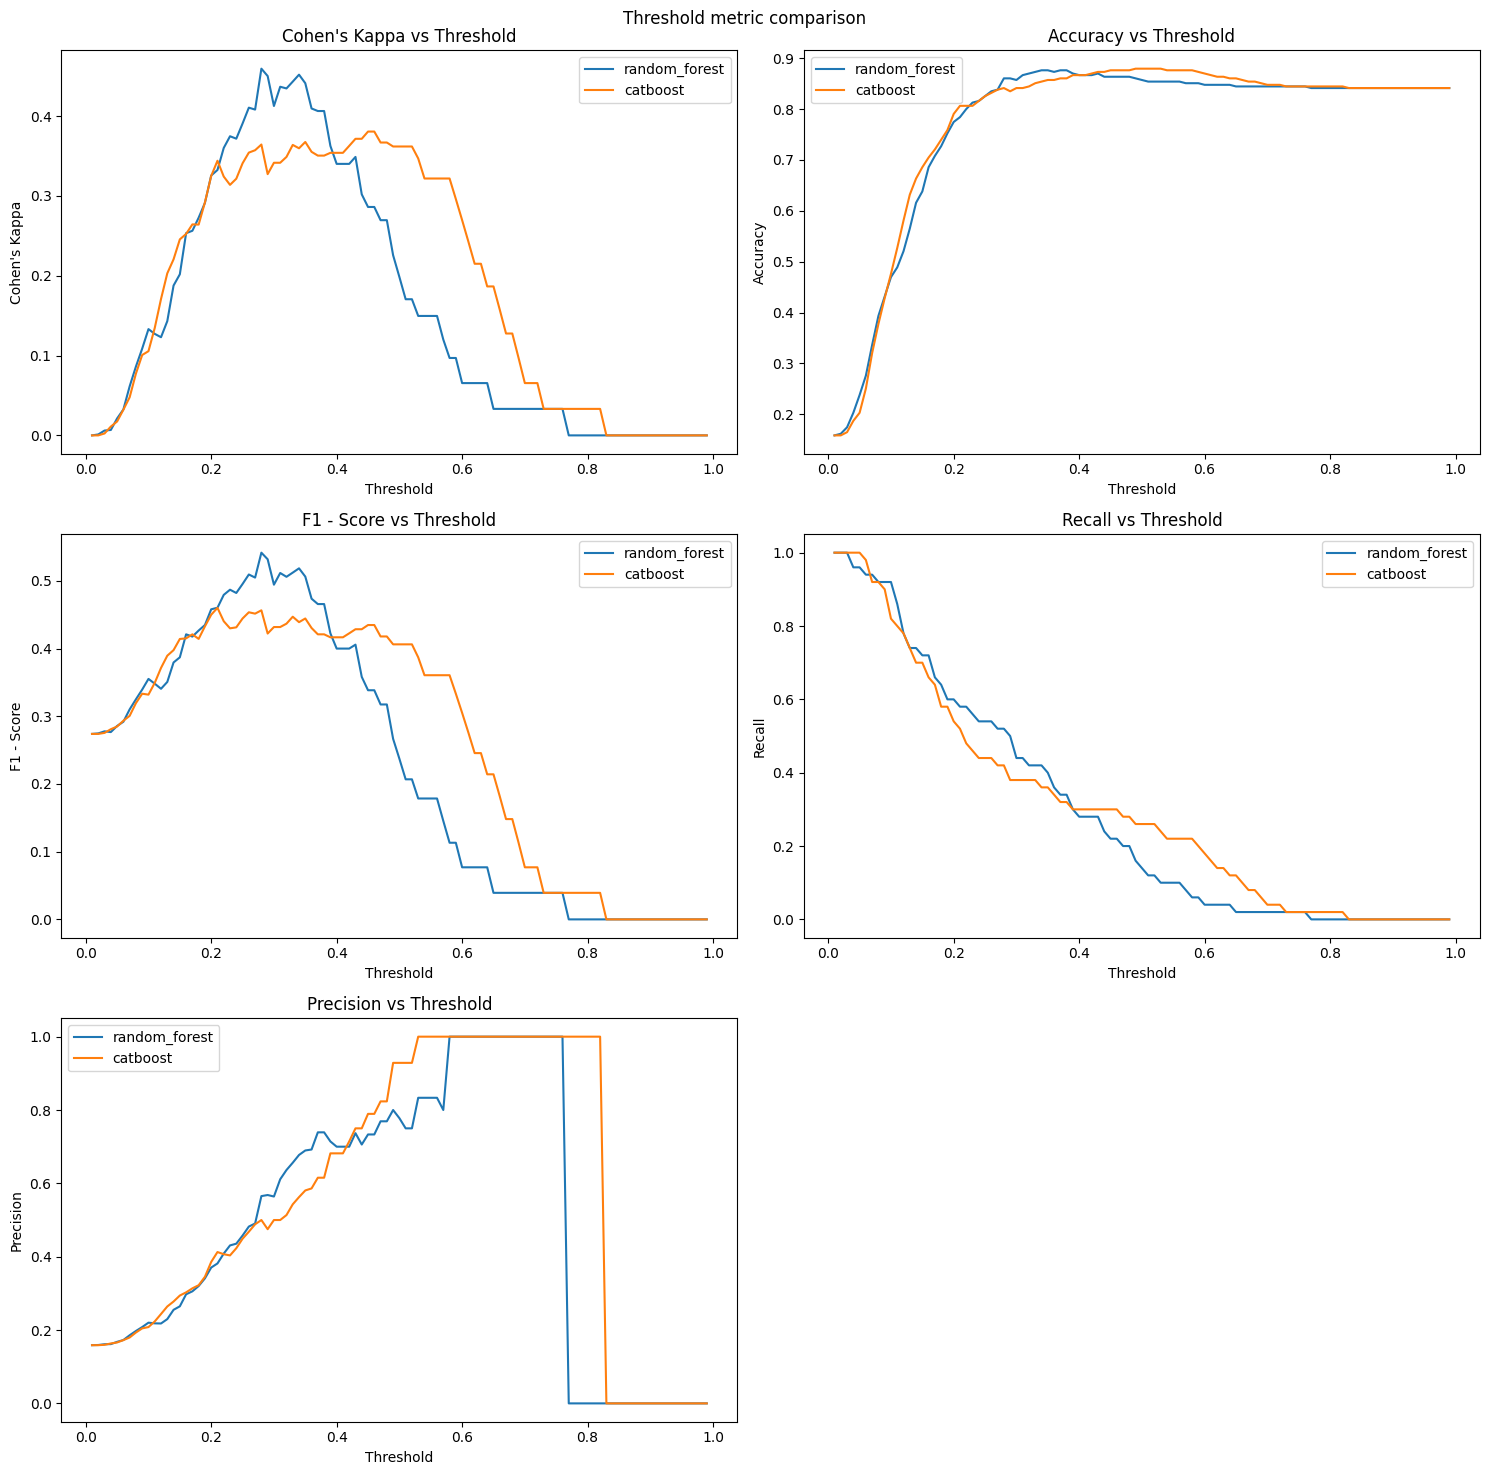

In [401]:
# get y_test and y_probs for each model
y_test = analista_clasificacion_1.y_test # same for all

# Random Forest 
y_probs_rf = analista_clasificacion_1.resultados["random_forest"]["pred_test_prob"]
y_pred_rf = analista_clasificacion_1.resultados["random_forest"]["pred_test"]

# CatBoost 
y_probs_cat = analista_clasificacion_3.resultados["catboost"]["pred_test_prob"]

# define list of scorers to plot together
scorer_list = [cohen_kappa_score, accuracy_score, f1_score, recall_score, precision_score]
scorer_names = ['Cohen\'s Kappa', 'Accuracy', 'F1 - Score', 'Recall', 'Precision']

mes.plot_score_by_threshold_multiple(["random_forest", "catboost"], 
                                 y_test=y_test, y_probs_list=[y_probs_rf,y_probs_cat], 
                                 scorer_list=scorer_list, scorer_name_list=scorer_names)

Now let's plot the ROC and Precision-Recall curves:

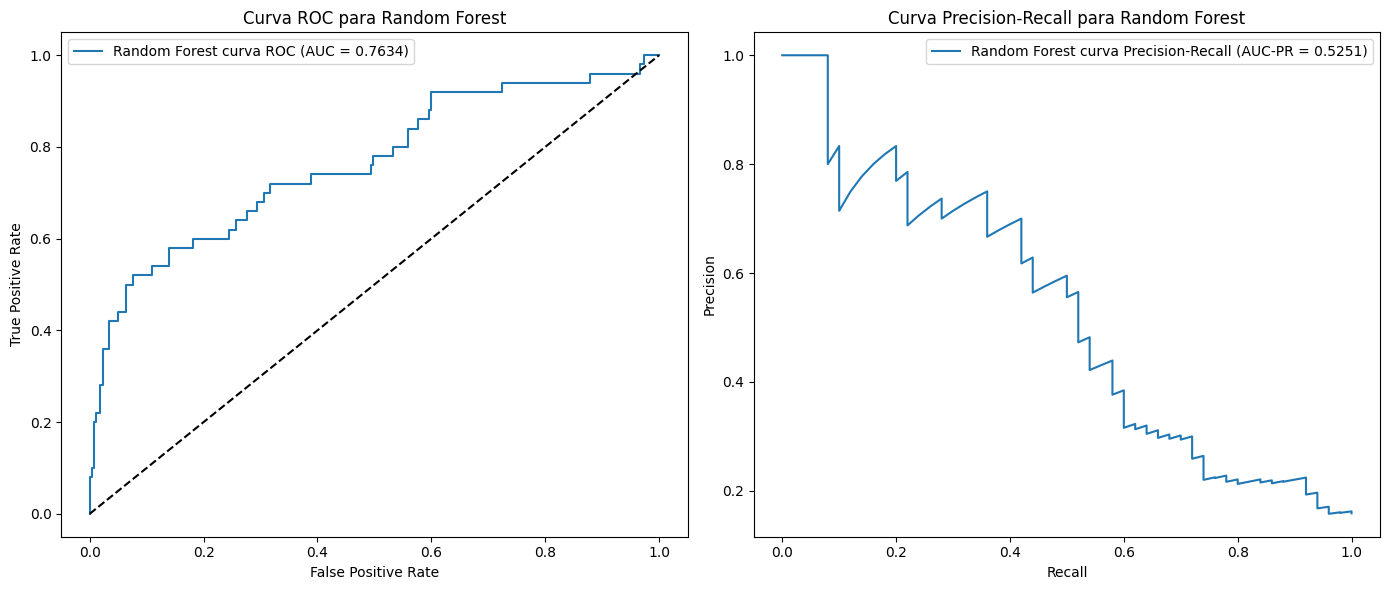

Random Forest - test AUC: 0.7634
Random Forest - test AUC-PR: 0.5251


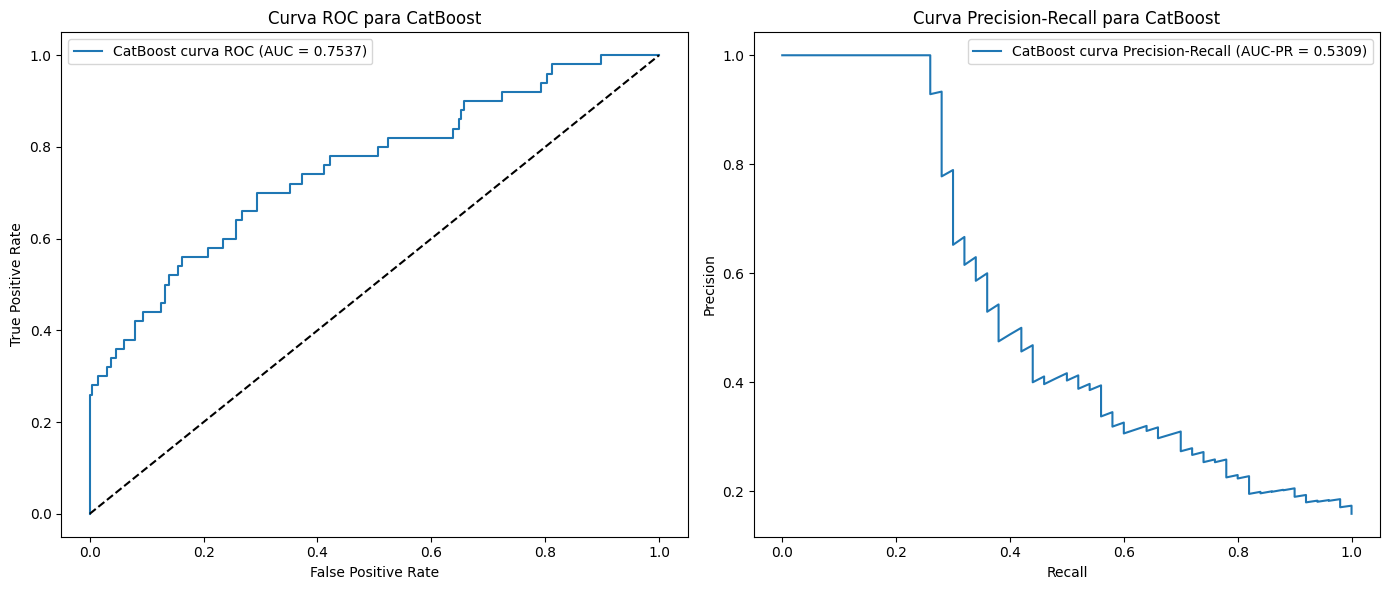

CatBoost - test AUC: 0.7537
CatBoost - test AUC-PR: 0.5309


In [ ]:
mes.plot_auc_and_aucpr("Random Forest", y_test, y_probs_rf)
mes.plot_auc_and_aucpr("CatBoost", y_test, y_probs_cat)

Looking at both curves, it seems that Random Forest performs better overall in terms of accuracy and f1-score when thresholds are at around 0.25-0.3, while Catboost performs a bit worse, but sustains performance for a wider threshold spectrum up to a higher threshold. Given that we are focused on maximizing Recall, while retaining the maximum Precision, it looks like Random Forest is the best option for our goals.

However, a more defined proportion between the 2 is needed. To be guided by a use case, in upcoming section `4.2.4` a business case for the model is proposed.

### 4.2.3 Explainability of the selected models

To interpret the predictions of the model and to understand how each model uses input variables, it is useful to look at both the integrated tree based feature importances and the SHAP values for them. Let us plot them:

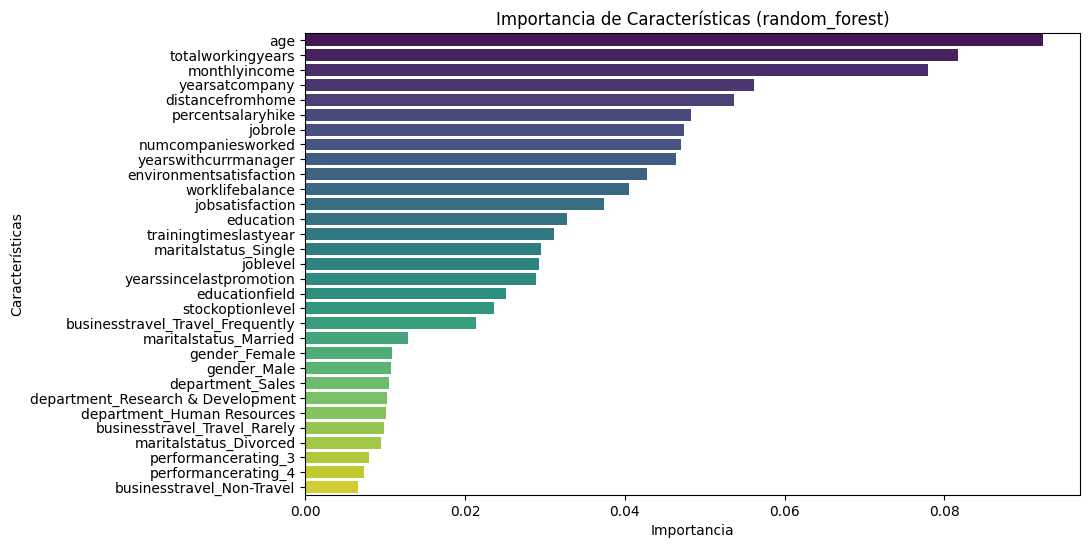

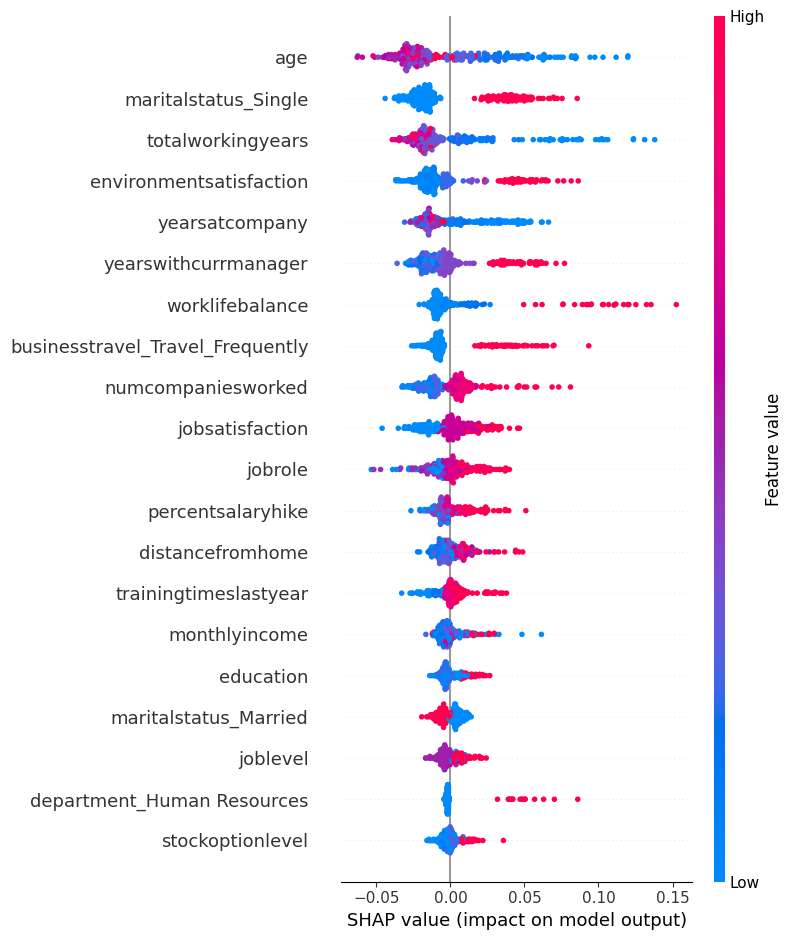

In [431]:
analista_clasificacion_1.importancia_predictores("random_forest", pipeline=True)
analista_clasificacion_1.plot_shap_summary("random_forest", pipeline=True)

Something that quickly strikes the eye is the fact that there are less features in the SHAP explainer plot than there are in the tree based importances. Moreover, the order of the features in the SHAP plot, which is supposed to more or less reflect the importance of the features, is not the same as the tree based one. This is due to different reasons:
1. SHAP values show the top 20 most important feature contributions unless stated otherwise.
2. Tree based importances compute Gini or Information gain metrics by summing the contribution of each split, the more a feature is used for splitting, the more it contributes. SHAP uses game theory to compute marginal contributions to each prediction, assigning weights to each predictions contribution to more accurately handle correlated variables and not being driven off by high cardinality features.

Given this discrepancy, we will look at the CatBoost plot too. Catboost will be an interesting model to use for feature importance inspection, as it computes the importance of the variable as a how, rather than the one-hot encoded importances. Let us plot its graphs to be able to contrast both and that way extract common insights of interest for future iterations of our models.

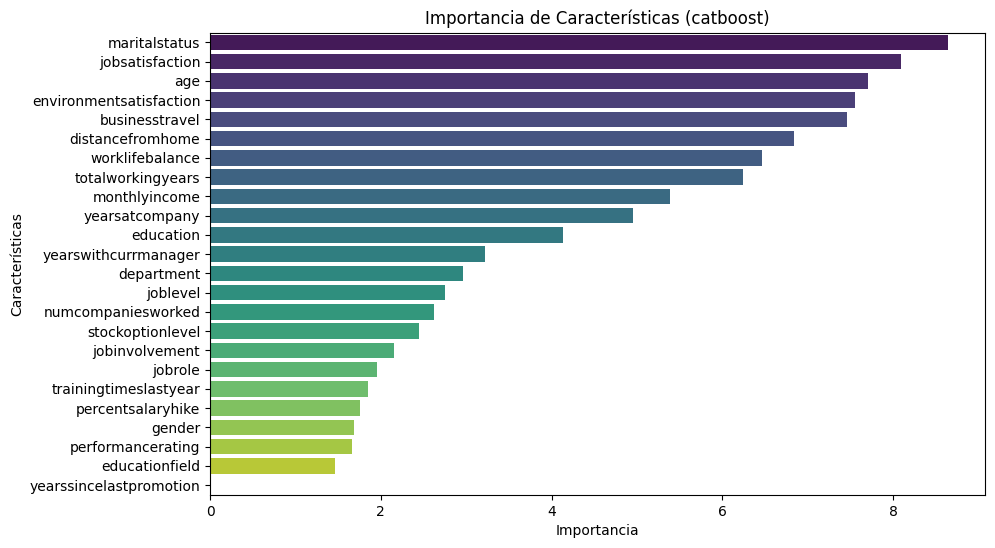

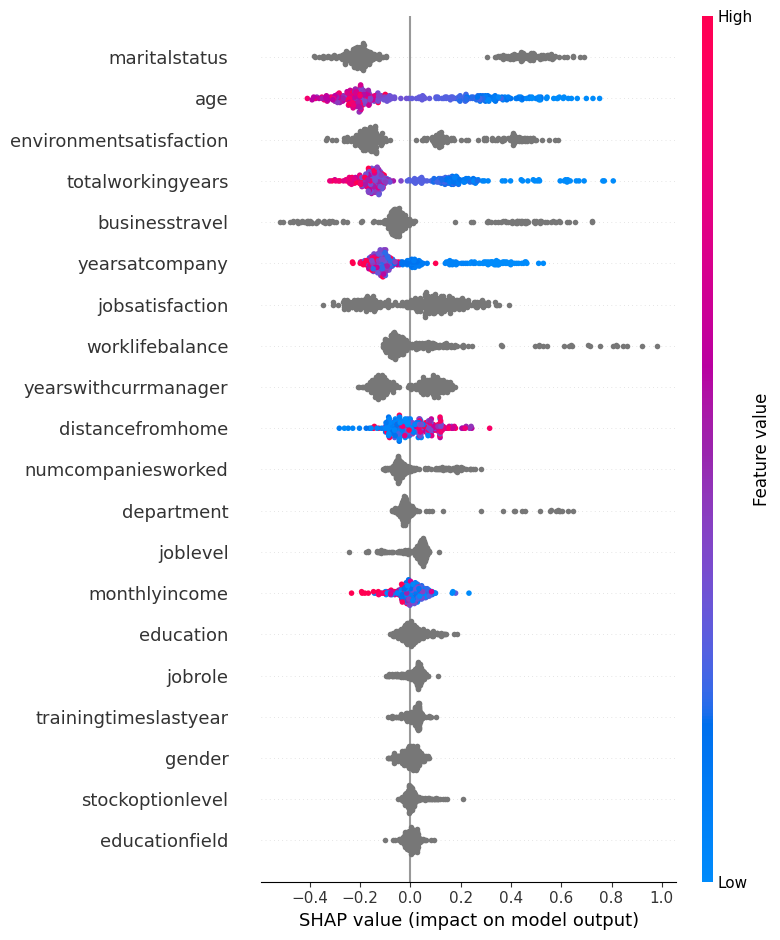

In [432]:
analista_clasificacion_3.importancia_predictores("catboost", pipeline=True)
analista_clasificacion_3.plot_shap_summary("catboost", pipeline=True)

Now looking at both Catboost and Random Forest, for both their feature importances and SHAP value contributions, we can see that:
- Age and marital status are, from the SHAP plot, the 2 most influential features, being the status of 'Single' the most influential one.
    - For Age, in both cases we see that older ages always contribute negatively to attrition, promoting employee stay. On the other hand, although young age is a high turnover driver for very young ages, that is not always the case for more middle aged employees.
- There is also consensus between both models in that Totalworkingyears and Environmentsatisfaction are the 2 other most important features.
    - Total working years shows the same behaviour as age.
    - Environment satisfaction cannot be further analysed, as being target encoded its values cannot be identified as the categories. Perhaps, sacrificing performance, it would be interesting to use custom ordinal encodings to discern the effect of each category. 
- Business travel, however, is more important for Catboost than for Random Forest. Does the one hot encoding of categories create this discrepancy?
    - A high frequency of travel contributes strongly and positively to the model.
- Years with current manager is a strong predictor as forecasted.
- Numcompaniesworked, jobrole and joblevel rank higher for Random Forest than for Catboost. It is interesting to see that the relationship explicited by target encoded is not followed perfectly by the Random Forest.

### 4.2.4 Precision-Recall trade-off comparison
For a business case comparison between the models, let's suppose:
- For every false negative (missed attrition), the company incurs a 70k rupee cost in recruiting and higher salary for a new employee.
- For every false positive (unnecessary retention effort), the company incurs a 10k rupee cost in salary rises and other human resources costs related to non-monetary employee benefits.

Then, the formula for the objective revenue saving, dependant on True Positives, False Negatives and False Positives is:

$$
\text{Revenue} = (70 - 10) \cdot TP - (70 \cdot FN) - (10 \cdot FP)
$$


In [421]:
# Random Forest
optimal_threshold_rf, max_revenue_rf = mes.maximize_revenue(y_true=y_test, y_probs=y_probs_rf)
print(f"Optimal threshold: {optimal_threshold_rf:.4f}")
print(f"Maximum revenue value saved: {max_revenue_rf:.2f}k Rupees for a total of {y_test.shape[0]} employees with Randon Forest")

# CatBoost
optimal_threshold_cat, max_revenue_cat = mes.maximize_revenue(y_true=y_test, y_probs=y_probs_cat)
print(f"\nOptimal threshold: {optimal_threshold_cat:.4f}")
print(f"Maximum revenue value saved: {max_revenue_cat:.2f}k Rupees for a total of {y_test.shape[0]} employees with CatBoost")

Optimal threshold: 0.1010
Maximum revenue value saved: 850.00k Rupees for a total of 315 employees with Randon Forest

Optimal threshold: 0.0909
Maximum revenue value saved: 610.00k Rupees for a total of 315 employees with CatBoost


The above means that, assumming the savings in revenue function is correct, the Random Forest model in production would save 850k rupees per 315 employees, while the CatBoost would save 610k. With these monetary metrics at hand, the selected model is Random Forest.

Finally, let's observe the confusion matrix for Random Forest at a clasfication threshold of 0.101:

Recall Score: 0.9200
Precision Score: 0.2201


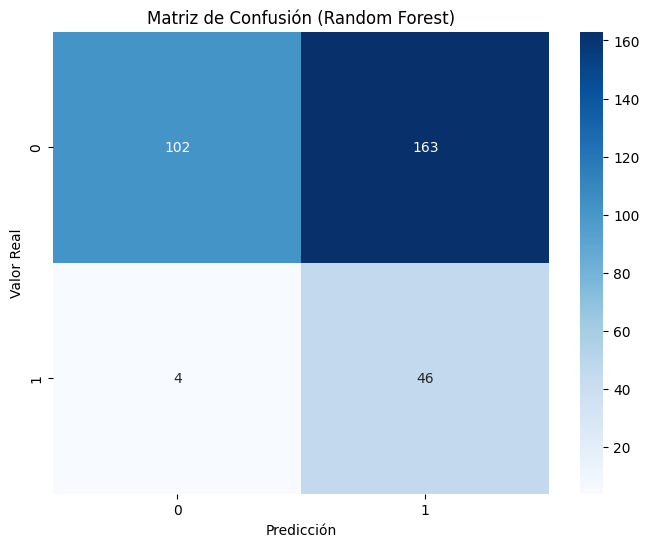

In [423]:
# calculating Precision and Recall for the optimal threshold
y_pred_optimized = (y_probs_rf >= optimal_threshold_rf).astype(int)

print(f"Recall Score: {recall_score(y_test, y_pred_optimized):.4f}")
print(f"Precision Score: {precision_score(y_test, y_pred_optimized):.4f}")

mes.plot_matriz_confusion("Random Forest", y_test, y_pred_optimized)

With the model selected, identify 92 out 100 employees that leave, being able to retain that talent. The cost is that about 4 out 5 of them would not really actually leave. 

### 4.2.5 Probability distribution of the selected model
One thing that is interesting to observe is the distribution of probabilities, of course, revolves around the mean value for the imbalance. In the distribution there is little probability of attrition and although we can extract some information for the data, it is not enough to completely separate the data from attrition 'Yes' and 'No'. Thus why the metrics are not close to 1 in any case, the classification threshold optimization is needed and why the calibration curve below is not perfectly fitted to a 1:1 line.

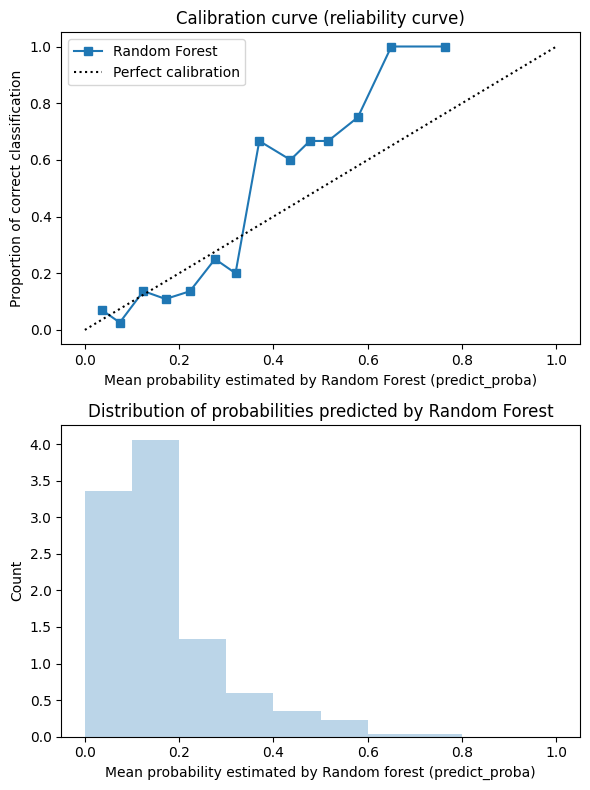

In [428]:
fraccion_positivos, media_prob_predicha = calibration_curve(y_test, y_probs_rf, n_bins=20)

fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*4))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Perfect calibration")
axs[0].set_ylabel("Proportion of correct classification")
axs[0].set_xlabel("Mean probability estimated by Random Forest (predict_proba)")
axs[0].set_title('Calibration curve (reliability curve)')
axs[0].legend()

axs[1].hist(y_probs_rf, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Mean probability estimated by Random forest (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribution of probabilities predicted by Random Forest')

plt.tight_layout()
plt.show()

The calibration curve above shows that the model incorrectly assigns low probabilities to observations where the proportion of attrition "Yes" is high. This could be a source of worry, but given the classification threshold chosen is below the point where the model starts to consistently underpredic, probability underprediction should not be an issue.

# 5. Deployment

A scoring deployment of the trained model has been performed in the form a Flask API present in `deployment/main.py`, that can be used through a streamlit application found in `streamlit/main.py`.

# 6. Final comments and next steps

**Next steps**
- Tune Random Forest further, as high
- [Explain a bit more] Explore how GridSearchCV can give worse results for a single parameter optimized, with options included that give better performance when alone. Assuming correct seed control. 
- Different employees might represent different ROIs of employee retention, thus, it might be a good a idea to either:
    - Develop different models for different profiles based on risk (costs vs. probability)
    - Apply different classification thresholds for different profiles
- Use ordinal or custom encodings to replace target ones, to allow for SHAP values interpretability.